In [1]:
from urllib.parse import unquote
import csv
import folium
import openrouteservice
from branca.element import Figure
from openrouteservice import convert
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pulp
from IPython.core.display import display
import os
import sys
import matplotlib as mpl
from itertools import product, combinations_with_replacement
from joblib import Parallel,delayed

waketa_list = []
datalist = []

with open('test_url.txt') as f:
    for line in f:
        waketa_list.append(line.split("/"))

for i in range(len(waketa_list)):
    chimei = unquote(waketa_list[i][5])
    zahyo_matomari = waketa_list[i][6].split(",")
    keido = zahyo_matomari[0][1:]
    ido = zahyo_matomari[1]
    datalist.append([chimei,keido,ido])
    
df_list = pd.DataFrame(datalist, columns=["地名","緯度","経度"])
df_list.to_csv("test_loc_pos.csv", index=False, encoding="utf_8")

C:\Users\yhira\AppData\Local\Temp\ipykernel_22068\2643069653.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


In [2]:
key = "5b3ce3597851110001cf624804ffaeec7cd246038d01eb4d3a32f633"
client = openrouteservice.Client(key=key)

datalist = []

with open("test_loc_pos.csv", encoding="utf_8") as f:
    reader = csv.reader(f)
    line = [row for row in reader]

for i in range(len(line)-2):
    p1 = float(line[i+1][1]), float(line[i+1][2])
    for j in range(i,len(line)-2):
        p2 = float(line[j+2][1]), float(line[j+2][2])
        print(p1,p2)
        p1r = tuple(reversed(p1))
        p2r = tuple(reversed(p2))
        mean_lat = (p1[0] + p2[0]) / 2
        mean_long = (p1[1] + p2[1]) / 2

        # 経路計算 (Directions V2)
        routedict = client.directions((p1r, p2r),profile="foot-walking")
        
        
        geom = routedict["routes"][0]["geometry"]
        decoded = convert.decode_polyline(geom)

        print(routedict["routes"][0]["summary"]["duration"])
        datalist.append([i,j+1,float(routedict["routes"][0]["summary"]["duration"])])
    
df_list = pd.DataFrame(datalist, columns=["出発地点","行先","移動時間[s]"])
df_list.to_csv("test_loc_loc_time.csv", index=False, encoding="utf_8")

(35.6311616, 139.7844807) (35.6305754, 139.7903577)
495.3
(35.6311616, 139.7844807) (35.649125, 139.787199)
2037.0
(35.6311616, 139.7844807) (35.6159392, 139.7611697)
2342.0
(35.6305754, 139.7903577) (35.649125, 139.787199)
2022.4
(35.6305754, 139.7903577) (35.6159392, 139.7611697)
2557.9
(35.649125, 139.787199) (35.6159392, 139.7611697)
3792.7


C:\Users\yhira\AppData\Local\Temp\ipykernel_22068\2364929968.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


[[   0.   710.3 2052.8 1319.1]
 [ 710.3    0.  2021.8 1579.2]
 [2052.8 2021.8    0.  3210.6]
 [1319.1 1579.2 3210.6    0. ]]


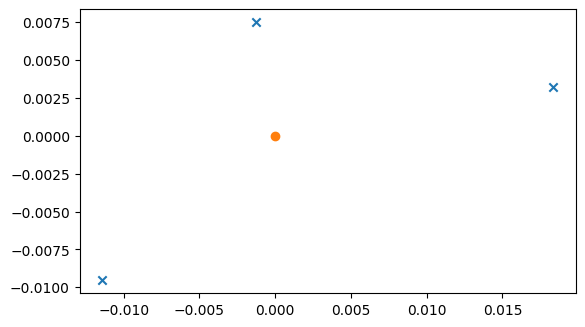

In [2]:
from IPython.core.display import display
import numpy as np
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import pulp
from itertools import product, combinations_with_replacement
from joblib import Parallel, delayed
import csv


places_data = pd.read_csv("geo_loc_pos.csv")
places_data_time = pd.read_csv("geo_loc_loc_time.csv")
num_places = len(places_data)
num_places_time = len(places_data_time)
num_days = 4
D = range(num_days)

with open("geo_loc_loc_time.csv", encoding="utf_8") as f:
    reader = csv.reader(f)
    loc_loc_time = [row for row in reader]
    
H_regular = 10*60*10  #制限時間


c = 5000000
K = range(num_places)
o_ = [float(places_data.iloc[0,1]) , float(places_data.iloc[0,2])] 
o = [o_[0] -o_[0] , o_[1] - o_[1]]
K_minus_o = K[1:]
_K = [o]
for i in range(1,num_places):
    _K.append([float(places_data.iloc[i,1]) -o_[0], float(places_data.iloc[i,2])- o_[1]])
_K  = np.array(_K)
t = [[0 for i in range(num_places)] for j in range(num_places)]
for i in range(num_places_time):
    t[int(loc_loc_time[i+1][0])][int(loc_loc_time[i+1][1])] = float(loc_loc_time[i+1][2])
    t[int(loc_loc_time[i+1][1])][int(loc_loc_time[i+1][0])] = float(loc_loc_time[i+1][2])
t = np.array(t)
print(t)

d_0 = np.random.choice(D,size=len(K))

k = np.random.choice(K_minus_o,size=len(K))

a = plt.subplot()
a.scatter(_K[1:,0],_K[1:,1],marker="x")
a.scatter(_K[0,0],_K[0,1],marker="o")
a.set_aspect("equal")
plt.show()

In [3]:
def simulate_route(z):
    if z[0] == 0:
        return None
    
    daily_route_prob = pulp.LpProblem(sense=pulp.LpMinimize)
    
    x = {
        (k,l):
            pulp.LpVariable(f"x_{k}_{l}",cat="Binary") if k != l else pulp.LpAffineExpression()
        for k , l in product(K,K)
    }
    
    u = {
        k: pulp.LpVariable(
            f"u_{k}",
            lowBound=1,
            upBound=len(K)-1,
        )
        for k in K_minus_o
    }
    
    
    h = pulp.LpVariable(f"h",lowBound=0,cat="Continuous")
    
    for l in K:
        daily_route_prob += pulp.lpSum([x[k,l] for k in K]) <= 1
        
    for l in K:
        if z[l] == 1:
            daily_route_prob += pulp.lpSum([x[k,l] for k in K]) == 1
            daily_route_prob += pulp.lpSum([x[l,k] for k in K]) == 1
        else:
            daily_route_prob += pulp.lpSum([x[k,l] for k in K]) == 0
            daily_route_prob += pulp.lpSum([x[l,k] for k in K]) == 0
            
    for k,l in product(K_minus_o,K_minus_o):
        daily_route_prob += u[k] + 1 <= u[l] + len(K_minus_o)*(1-x[k,l])
    
    travel = pulp.lpSum([t[k,l]*x[k,l] for k , l in product(K,K)])
    
    daily_route_prob += travel - H_regular <= h
    
    daily_route_prob += travel
    daily_route_prob.solve()
    
    return{
        "z": z,
        "route": {
            (k,l): x[k,l].value() for k,l in product(K,K)
        },
        "optimal": daily_route_prob.status == 1,
        "移動時間": travel.value(),
        "残業時間":h.value(),
    }
    
def enumerate_routes():
    routes = Parallel(n_jobs=16)(
        [delayed(simulate_route)(z) for z in product([0,1], repeat=len(K))]
    )
    
    routes = pd.DataFrame(filter(lambda x:x is not None,routes))
    
    routes = routes[routes.optimal].copy()
    return routes

routes_df = enumerate_routes()

routes_df

,z,route,optimal,移動時間,残業時間
1,"(1, 0, 0, 1)","{(0, 0): 0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): ...",True,2638.2,0.0
2,"(1, 0, 1, 0)","{(0, 0): 0, (0, 1): 0.0, (0, 2): 1.0, (0, 3): ...",True,4105.6,0.0
3,"(1, 0, 1, 1)","{(0, 0): 0, (0, 1): 0.0, (0, 2): 1.0, (0, 3): ...",True,6582.5,582.5
4,"(1, 1, 0, 0)","{(0, 0): 0, (0, 1): 1.0, (0, 2): 0.0, (0, 3): ...",True,1420.6,0.0
5,"(1, 1, 0, 1)","{(0, 0): 0, (0, 1): 1.0, (0, 2): 0.0, (0, 3): ...",True,3608.6,0.0
6,"(1, 1, 1, 0)","{(0, 0): 0, (0, 1): 1.0, (0, 2): 0.0, (0, 3): ...",True,4784.9,0.0
7,"(1, 1, 1, 1)","{(0, 0): 0, (0, 1): 0.0, (0, 2): 1.0, (0, 3): ...",True,6972.9,972.9


In [8]:
def is_OK(requests):
    # 指定された荷物の配送が重量制約のもとで可能かを確認する
    # 可能である場合は配送を実行できる最短の移動経路のインデックス (routes_df におけるもの) とその所要時間を返す
    # 不可能であれば，False を返す
    # requests: K に含まれるリストで，配送する荷物の一覧を表す
    
    weight = sum([w[r] for r in requests])
    if weight > W:
        return False
    
    # ルート関係
    best_route_idx = None
    best_hours = sys.float_info.max
    for route_idx, row in routes_df.iterrows():
        all_requests_on_route = all([row.z[k[r]] == 1 for r in requests])
        if all_requests_on_route and row.移動時間 < best_hours:
            best_route_idx = route_idx
            best_hours = row.移動時間
    if best_route_idx is None:
        return False
    else:
        return best_route_idx, best_hours

    
def _enumerate_feasible_schedules(requests_cands, current_idx_set, idx_to_add, res):
    # K に含まれるリスト requests_cands を候補として
    # current_idx_set で指定される荷物に加えて配送することができる
    # requests_cands[idx_to_add:] の部分集合をすべて列挙する．（再帰的に計算する）
    # 配送可能な荷物の集合は， リスト res に追加される
    
    # idx_set_to_check = current_idx_set + [idx_to_add] で指定される
    # 荷物が配送可能かを確認する．
    idx_set_to_check = current_idx_set + [idx_to_add]
    next_idx = idx_to_add + 1
    is_next_idx_valid = next_idx < len(requests_cands)
    requests = [requests_cands[i] for i in idx_set_to_check]
    is_ok = is_OK(requests)
    
    if is_ok:
        # idx_set_to_check で指定される荷物が配送可能であれば，
        # その配送に用いられる移動経路の情報を記録する．
        best_route_idx, best_hour = is_ok
        res.append(
            {
                'requests': [requests_cands[i] for i in idx_set_to_check], 
                'route_idx': best_route_idx, 
                'hours': best_hour
            }
        )
        if is_next_idx_valid:
            # さらに荷物を追加できるかを確認する．
            _enumerate_feasible_schedules(requests_cands, idx_set_to_check, next_idx, res)
    if is_next_idx_valid:
        # idx_to_add をスキップして， next_idx 以降の荷物が追加できるかを確認する．
        _enumerate_feasible_schedules(requests_cands, current_idx_set, next_idx, res)

        
def enumerate_feasible_schedules(d: int):
    # _enumerate_feasible_schedules を用いて d 日に考慮すべきスケジュールを列挙する．
    
    # 配送日指定に合うものだけを探索する
    requests_cands = [r for r in K if d_0[r] <= d]

    # res に d 日の実行可能なスケジュールを格納する
    res = [
        {'requests': [], 'route_idx': 0, 'hours': 0}
    ]
    #_enumerate_feasible_schedules(requests_cands, [], 0, res)

    # res を DataFrame 型にして後処理に必要な値を計算
    feasible_schedules_df = pd.DataFrame(res)
    feasible_schedules_df['overwork'] = (feasible_schedules_df.hours - H_regular).clip(0)
    feasible_schedules_df['requests_set'] = feasible_schedules_df.requests.apply(set)

    # feasible_schedules_df のうち，不要なスケジュールを削除する．
    # すなわちあるスケジュールが別のスケジュールに対して
    #   - 配送する荷物の集合の包含関係での比較
    #   - 残業時間の比較
    # の2つの比較で同時に負けている場合には，そのスケジュールは利用価値がないため，破棄する．
    
    # 残すスケジュールの index の候補
    idx_cands = set(feasible_schedules_df.index)
    # 破棄するスケジュールの index の候補
    dominated_idx_set = set()
    for dominant_idx in feasible_schedules_df.index:
        for checked_idx in feasible_schedules_df.index:
            # 配送する荷物の集合の包含関係での比較
            requests_strict_dominance = (
                feasible_schedules_df.requests_set.loc[checked_idx] < 
                feasible_schedules_df.requests_set.loc[dominant_idx] 
            ) 
            # 残業時間の比較
            overwork_weak_dominance = (
                feasible_schedules_df.overwork.loc[checked_idx] >=
                feasible_schedules_df.overwork.loc[dominant_idx]                 
            )
            if requests_strict_dominance and overwork_weak_dominance:
                dominated_idx_set.add(checked_idx)
                
    nondominated_idx_set = idx_cands - dominated_idx_set
    nondominated_feasible_schedules_df = feasible_schedules_df.loc[nondominated_idx_set, :]
    return nondominated_feasible_schedules_df

_schedules = Parallel(n_jobs=16)([delayed(enumerate_feasible_schedules)(d) for d in D] )
feasible_schedules = dict(zip(D, _schedules))


In [12]:
prob = pulp.LpProblem(sense=pulp.LpMinimize)

# ■ 変数
# 日毎にどの配送計画を採用するか
z = {}
for d in D:
    for q in feasible_schedules[d].index:
        z[d, q] = pulp.LpVariable(f'z_{d}_{q}', cat='Binary')

# 配送を外注するかどうかの補助変数

# ■ 制約・目的関数定義の準備
# 荷物 r の配送の回数を y, z の言葉で表現しておく
deliv_count = {r: pulp.LpAffineExpression() for r in K}
for d in D:
    for q in feasible_schedules[d].index:
        for r in feasible_schedules[d].loc[q].requests:
            deliv_count[r] += z[d, q]

# 日付 d の残業時間を y, z の言葉で表現しておく
h = {
    d: pulp.lpSum(
        z[d, q] * feasible_schedules[d].overwork.loc[q]
        for q in feasible_schedules[d].index
    )
    for d in D
}

# ■ 制約
# 1日1つのスケジュールを選択する
for d in D: 
    prob += (
        pulp.lpSum(z[d, q] for q in feasible_schedules[d].index) == 1
    )

# y が外部委託による配送を表すように
for r in K:
    prob += (
        y[r] >= 1 - deliv_count[r]
    )
    
# ■ 目的関数
obj_overtime = pulp.lpSum([c * h[d] for d in D])
#obj_outsorcing = pulp.lpSum(
    #[f[r] * y[r] for r in K]
#)

obj_total = obj_overtime
prob += obj_total    


# ■ 求解
prob.solve()

1

In [34]:
# 日毎に可視化
def visualize_route(d):
    for q in feasible_schedules[d].index:
        if z[d, q].value() > 0.5:
            route_summary = feasible_schedules[d].loc[q]  
            route_geography = routes_df.loc[route_summary.route_idx]
            break
            
    # 背景
    a = plt.subplot()
    a.scatter(_K[1:,0], _K[1:,1], marker='x')
    a.scatter(_K[0,0], _K[0,1], marker='o')
    
    
    # 移動経路
    motions = [(k_from, k_to) for (k_from, k_to), used in route_geography.route.items() if used > 0]
    for k_from, k_to in motions:
        p_from = _K[int(k_from)]
        p_to =  _K[int(k_to)]
        a.arrow(
            *p_from, *(p_to-p_from), 
            head_width=3,
            length_includes_head=True,
            overhang=0.5,
            color='gray',
            alpha=0.5
        )
        
        requests_at_k_to = [r for r in route_summary.requests if k[r] == k_to]      
        a.text(*p_to, ' '.join([str(r) for r in requests_at_k_to]))
        
    plt.title(f'Schedule for day: {d}')
    plt.show()

In [35]:
visualize_route(0)

KeyError: 0